In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from pre_processing import *
from feature_selection import *
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", 10, "display.max_columns", None)

In [2]:
#store the csv of the stations into a list of dataframes
PATH = './Train/Train'
df = load_individual(PATH)
df[5]
#has_nan(df[5])

,station,latitude,longitude,numDocks,timestamp,year,month,day,hour,weekday,weekhour,isHoliday,windMaxSpeed.m.s,windMeanSpeed.m.s,windDirection.grades,temperature.C,relHumidity.HR,airPressure.mb,precipitation.l.m2,bikes_3h_ago,full_profile_3h_diff_bikes,full_profile_bikes,short_profile_3h_diff_bikes,short_profile_bikes,bikes
0,253,39.485811,-0.396678,20,1.412114e+09,2014,10,1,0,Wednesday,49,0,11.3,3.2,67.5,21.3,85.0,855.3,0.0,NaN,NaN,NaN,NaN,NaN,1.0
1,253,39.485811,-0.396678,20,1.412118e+09,2014,10,1,1,Wednesday,50,0,1.6,0.0,157.5,21.1,86.0,1000.6,0.0,NaN,NaN,NaN,NaN,NaN,1.0
2,253,39.485811,-0.396678,20,1.412122e+09,2014,10,1,2,Wednesday,51,0,1.6,0.0,112.5,20.9,86.0,880.6,0.0,NaN,NaN,NaN,NaN,NaN,1.0
3,253,39.485811,-0.396678,20,1.412125e+09,2014,10,1,3,Wednesday,52,0,0.0,0.0,146.3,20.4,88.0,859.8,0.0,1.0,NaN,NaN,NaN,NaN,0.0
4,253,39.485811,-0.396678,20,1.412129e+09,2014,10,1,4,Wednesday,53,0,6.4,3.2,157.5,20.3,87.0,898.1,0.0,1.0,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,253,39.485811,-0.396678,20,1.414778e+09,2014,10,31,19,Friday,116,0,9.7,4.8,22.5,20.2,80.0,1023.5,0.0,1.0,1.00,6.00,1.00,6.00,2.0
741,253,39.485811,-0.396678,20,1.414782e+09,2014,10,31,20,Friday,117,0,6.4,1.6,337.5,20.2,82.0,1023.9,0.0,5.0,1.50,4.50,1.50,4.50,3.0
742,253,39.485811,-0.396678,20,1.414786e+09,2014,10,31,21,Friday,118,0,3.2,0.0,315.0,20.0,83.0,1024.0,0.0,3.0,-2.00,4.25,-2.00,4.25,5.0
743,253,39.485811,-0.396678,20,1.414789e+09,2014,10,31,22,Friday,119,0,0.0,0.0,146.3,19.3,84.0,1024.4,0.0,2.0,-2.75,3.25,-2.75,3.25,9.0


In [3]:
#drop instance where there's no number of bikes
df = list(map(drop_nan_bikes, df))

#replaces days with numbers
df = list(map(day_dummies, df))

#impute missing data
df = list(map(nan_impute, df))

#removes features with zero variance
df = list(map(var_transform, df))

In [4]:
#find which feature has highest correlation with bikes
for i in range(len(df)):
    corr_matrix = correl(df[i])
    print(corr_matrix['bikes'].sort_values(ascending=False).head(5))

bikes           1.000000
bikes_3h_ago    0.818723
isHoliday       0.405647
timestamp       0.204135
day             0.202558
Name: bikes, dtype: float64
bikes                  1.000000
hour                   0.357543
short_profile_bikes    0.343616
full_profile_bikes     0.343616
temperature.C          0.322818
Name: bikes, dtype: float64
bikes                          1.000000
short_profile_bikes            0.618843
full_profile_bikes             0.618843
bikes_3h_ago                   0.534393
short_profile_3h_diff_bikes    0.224928
Name: bikes, dtype: float64
bikes              1.000000
bikes_3h_ago       0.847166
isHoliday          0.293302
weekday_Sunday     0.292779
weekday_Tuesday    0.228991
Name: bikes, dtype: float64
bikes                         1.000000
bikes_3h_ago                  0.544849
day                           0.137003
timestamp                     0.135788
full_profile_3h_diff_bikes    0.128969
Name: bikes, dtype: float64
bikes                          1.000000


Find inter-feature correlation

In [1]:
sns.heatmap(df[4].corr(), vmin=-1.0, vmax=1.0)

for i in range(len(df)):
    dropped = high_correl(df[i], 0.95)
    print(dropped)


NameError: name 'sns' is not defined

### MODEL SELECTION
In the following cell we explore different models, using standard hyperparameters. Use pipeline to first standar-scale
our instances (remove the mean and set to unitary variance), then fit the model using cross validation. Note that the
scaler is fitted only on the training data and applied on the test only after, in order to avoid contamination of the
test set.

In [7]:
X = []
Y = []


scores = []

for i in range(len(df)):

    #store features and target in two different dataframes
    X.append(df[i].loc[:, df[i].columns != 'bikes'])
    Y.append(df[i]['bikes'])

    #split into train and test data
    X_train, X_test, Y_train, Y_test = train_test_split(X[i], Y[i], test_size=.20)

    pipelines = [('LinearRegression', Pipeline([('Scaler', RobustScaler()),('LR',LinearRegression())])),
                 ('Ridge', Pipeline([('Scaler', RobustScaler()),('L2',Ridge())])),
                 ('DecisionTrees',Pipeline([('Scaler', RobustScaler()),('DT',DecisionTreeRegressor())])),
                 ('RandomForest',Pipeline([('Scaler', RobustScaler()),('RF',RandomForestRegressor())])),
                 ('GradientBoosting', Pipeline([('Scaler', RobustScaler()),('LGB',lgb.LGBMRegressor())])),
                 ('KNN',Pipeline([('Scaler', RobustScaler()),('KNN',KNeighborsRegressor())])),
                 ('SVR',Pipeline([('Scaler', RobustScaler()),('SVR',SVR())]))]
    temp_scores = []
    for model, pipeline in pipelines:
        cv_scores = cross_val_score(pipeline, X_train, Y_train, cv=5, scoring='neg_mean_absolute_error')
        print(f'Dataframe {i}, model {model} : {cv_scores.mean()}')
        temp_scores.append(cv_scores.mean())
    print("\n")
    scores.append(temp_scores)

Dataframe 0, model LinearRegression : -1.4408748968885192
Dataframe 0, model Ridge : -1.4407556096362855
Dataframe 0, model DecisionTrees : -1.3394957983193279
Dataframe 0, model RandomForest : -1.0933277310924367
Dataframe 0, model GradientBoosting : -1.0625373034786416
Dataframe 0, model KNN : -1.438655462184874
Dataframe 0, model SVR : -1.4035173079236998


Dataframe 1, model LinearRegression : -1.9529973749893696
Dataframe 1, model Ridge : -1.9526219497245716
Dataframe 1, model DecisionTrees : -1.971428571428571
Dataframe 1, model RandomForest : -1.575546218487395
Dataframe 1, model GradientBoosting : -1.5480149664548706
Dataframe 1, model KNN : -1.886050420168067
Dataframe 1, model SVR : -1.8888036333894882


Dataframe 2, model LinearRegression : -3.660825962355432
Dataframe 2, model Ridge : -3.6585141171651783
Dataframe 2, model DecisionTrees : -2.6521008403361344
Dataframe 2, model RandomForest : -2.3450084033613448
Dataframe 2, model GradientBoosting : -2.4223812422970905
Dataf

Calculate the mean per model

In [ ]:
avg = [float(sum(col))/len(col) for col in zip(*scores)]
avg

In [9]:
avg = pd.Series(avg, index=[model for model, pipeline in pipelines])

avg

LinearRegression   -2.716925
Ridge              -2.716838
DecisionTrees      -2.435541
RandomForest       -1.982814
GradientBoosting   -1.912599
KNN                -2.599104
SVR                -2.758978
dtype: float64

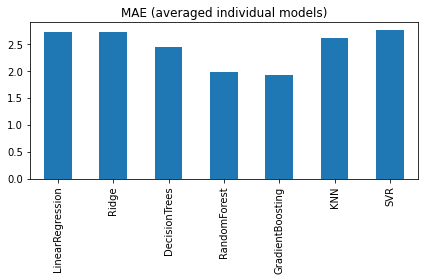

In [14]:
ax = avg.abs().plot.bar(title='MAE (averaged individual models)')
fig = ax.get_figure()
plt.tight_layout()
fig.savefig('individual_models.eps')

## Random forest tuning

In [10]:
# param_grid_forest = {'n_estimators': np.arange(200, 2000, 10),
#           'max_features': ['auto', 'sqrt'],
#           'max_depth': [np.arange(5, 100, 8), None],
#           'min_samples_split': [2, 5, 10],
#           'min_samples_leaf': [1, 2, 4],
#             'bootstrap': [True, False]
#          }
#
# tree_reg = RandomizedSearchCV(estimator = RandomForestRegressor(),
#                               param_distributions = param_grid_forest, n_iter = 100,
#                               verbose = 0, n_jobs = -3, cv=5, scoring='neg_mean_absolute_error')
# print(f"Starting training for dataset {i}...")
# tree_reg.fit(X_train, Y_train)
# print(f'Best parameters for dataset {i} are {tree_reg.best_params_}')
# print(f'Best score is {tree_reg.best_score_}')
# val_score.append(tree_reg.best_score_)
# score_on_test = tree_reg.score(X_test, Y_test)
# print(f"The MAE on the test set is {score_on_test}\n\n")
# test_score.append(score_on_test)

Starting training for dataset 74...


NameError: name 'X_train' is not defined

In [ ]:
# linear_model = linear_model.LinearRegression()
# #model = RandomForestRegressor()
# #model = DecisionTreeRegressor(criterion='mae')
# #model = AdaBoostRegressor(base_estimator=linearmodel, n_estimators=100, learning_rate=0.1)
#
# #performs cross validation
# scores = cross_val_score(linear_model, X_train, Y_train, scoring='neg_mean_absolute_error')
# #print(scores)
# #print(f'{scores.mean()}+-{scores.std()}')
# val_score.append((scores.mean()))
# #model.fit(X_train, Y_train)
# #calculate the score
# test_score.append(linear_model.score(X_test, Y_test))
#
#
# print(f"The mean MAE on validation set is {mean(val_score)}, and for the test set {mean(test_score)}.")
# #print(f'\n And the total MAE is {mean(tot_score)}')
#

In [24]:
# sorted(dict(zip(X_train.columns, tree_reg.best_estimator_.feature_importances_)).items(), key=lambda x: x[1], reverse=True)
#

[('full_profile_bikes', 0.2874053670115091),
 ('hour', 0.27860141344230865),
 ('timestamp', 0.20938289607181973),
 ('weekday', 0.05164292337370187),
 ('bikes_3h_ago', 0.04120490236620471),
 ('temperature.C', 0.038683392495332335),
 ('full_profile_3h_diff_bikes', 0.03406804824694994),
 ('airPressure.mb', 0.030363575739985698),
 ('relHumidity.HR', 0.02864748125218818),
 ('isHoliday', 0.0),
 ('windMaxSpeed.m.s', 0.0),
 ('windDirection.grades', 0.0)]

In [ ]:
# a = scatter_matrix(df[1], figsize=(20,20));
# [s.xaxis.label.set_rotation(45) for s in a.reshape(-1)]
# [s.yaxis.label.set_rotation(0) for s in a.reshape(-1)]
#
# plt.savefig('figure.png')